In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy


In [2]:
dataset_dir_path = r"C:\Users\Hassan Hallal\OneDrive\Desktop\waste\sort"
CONFIF = {
    "IMG_SIZE" : 256,
    "BATCH_SIZE": 32,
 }

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    image_size=(CONFIF["IMG_SIZE"], CONFIF["IMG_SIZE"]),
    batch_size=CONFIF["BATCH_SIZE"]
)

Found 1874 files belonging to 2 classes.
Using 1500 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir_path,
    validation_split=0.2,
    seed = 123,
    subset="validation",
    image_size=(CONFIF["IMG_SIZE"], CONFIF["IMG_SIZE"]),
    batch_size=CONFIF["BATCH_SIZE"],
    shuffle=True
    )

Found 1874 files belonging to 2 classes.
Using 374 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['nonrecycle', 'recycle']


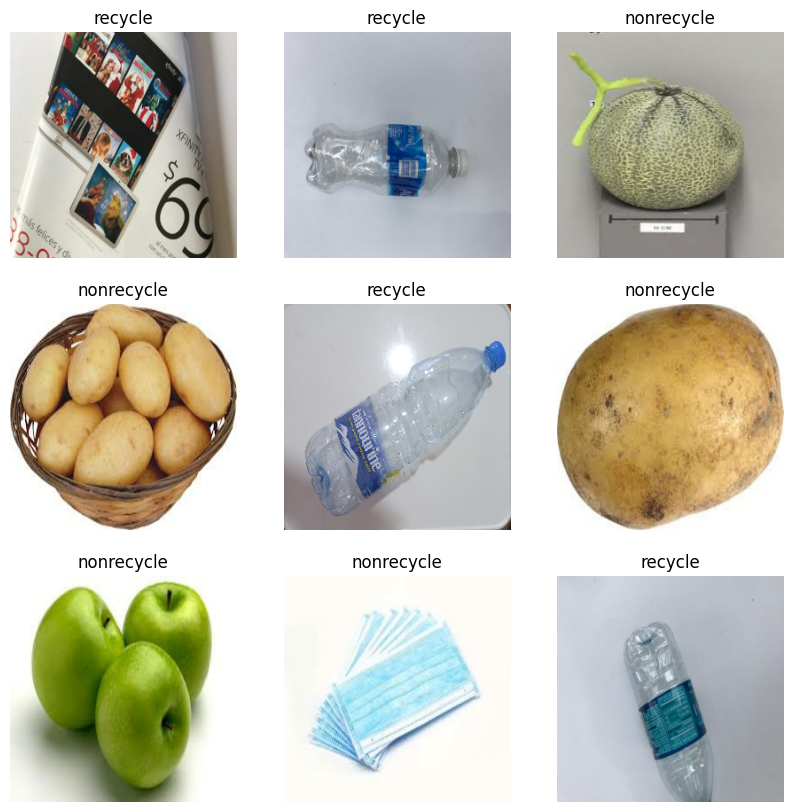

In [6]:
plt.figure(figsize=(10, 10))

for images,lables in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        true_label = class_names[lables[i].numpy()]
        plt.title(true_label)
        plt.imshow(images[i].numpy().astype("uint8"))
        ax.axis("off")


In [7]:
data_augmentation_layers = Sequential([
    layers.Input((CONFIF["IMG_SIZE"], CONFIF["IMG_SIZE"], 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

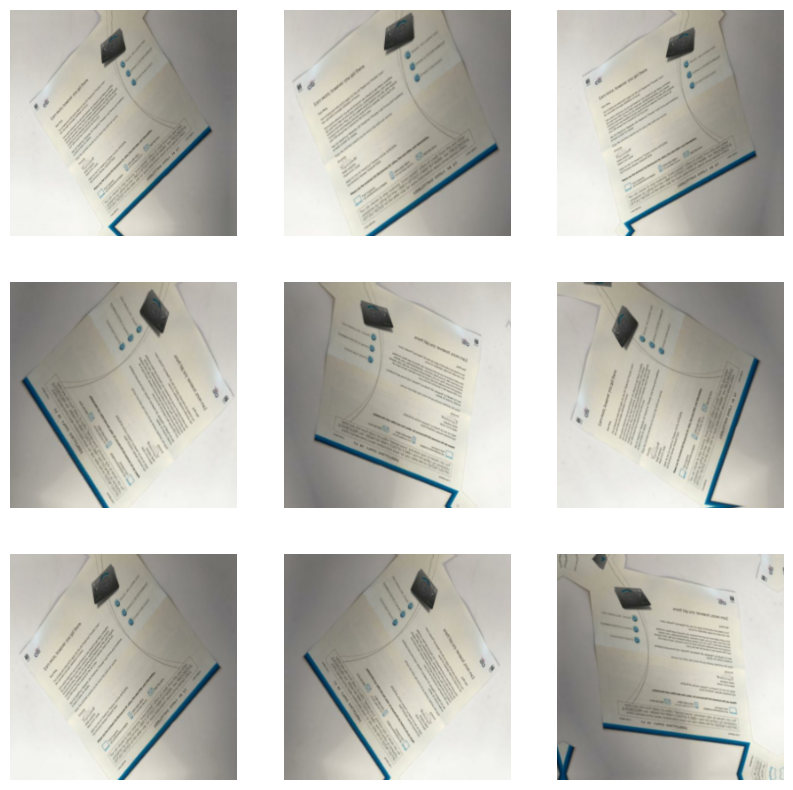

In [8]:
plt.figure(figsize=(10, 10))

for images,lables in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation_layers(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
train_ds = train_ds.shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [10]:
print(train_ds)
print(val_ds)

print(f"{len(train_ds)}")
print(f"{len(val_ds)}")

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
47
12


In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(CONFIF["IMG_SIZE"], CONFIF["IMG_SIZE"], 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

C:\Users\Hassan Hallal\AppData\Local\Temp\ipykernel_33088\334678045.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(CONFIF["IMG_SIZE"], CONFIF["IMG_SIZE"], 3),


In [12]:
mobile_net_model = tf.keras.Sequential([
    layers.Input((CONFIF["IMG_SIZE"], CONFIF["IMG_SIZE"], 3)),
    data_augmentation_layers,
    layers.Rescaling(1./255),

    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
mobile_net_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss= BinaryCrossentropy(),       
    metrics=['accuracy']
)
    #initial_epoch=30,
    #epochs=40,

In [14]:
from sklearn.utils import class_weight

# Create array of all labels
all_labels = []
for _, labels in train_ds:
    all_labels.extend(labels.numpy())

# Compute class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

class_weight_dict = dict(enumerate(weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(1.0273972602739727), 1: np.float64(0.974025974025974)}


In [15]:
history = mobile_net_model.fit(train_ds,
                    validation_data=val_ds,
                    batch_size=CONFIF["BATCH_SIZE"],
                    epochs=50,
                    class_weight=class_weight_dict)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 34s 625ms/step - accuracy: 0.6640 - loss: 0.6103 - val_accuracy: 0.9011 - val_loss: 0.2972
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 647ms/step - accuracy: 0.8926 - loss: 0.2898 - val_accuracy: 0.9278 - val_loss: 0.2052
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 650ms/step - accuracy: 0.9334 - loss: 0.2033 - val_accuracy: 0.9385 - val_loss: 0.1672
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 651ms/step - accuracy: 0.9517 - loss: 0.1509 - val_accuracy: 0.9572 - val_loss: 0.1304
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 671ms/step - accuracy: 0.9718 - loss: 0.1301 - val_accuracy: 0.9572 - val_loss: 0.1191
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 655ms/step - accuracy: 0.9767 - loss: 0.1060 - val_accuracy: 0.9572 - val_loss: 0.1095
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 673ms/step - accuracy: 0.9744 - loss: 0.0880 - val_accuracy: 0.9652 - val_loss: 0.1023
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 662ms/step - accuracy: 0.9682 - loss: 0.0954 - val_accu

In [16]:
mobile_net_model.evaluate(val_ds,verbose=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 421ms/step - accuracy: 0.9736 - loss: 0.0998


[0.06373350322246552, 0.9839572310447693]

In [17]:
base_model.trainable = True

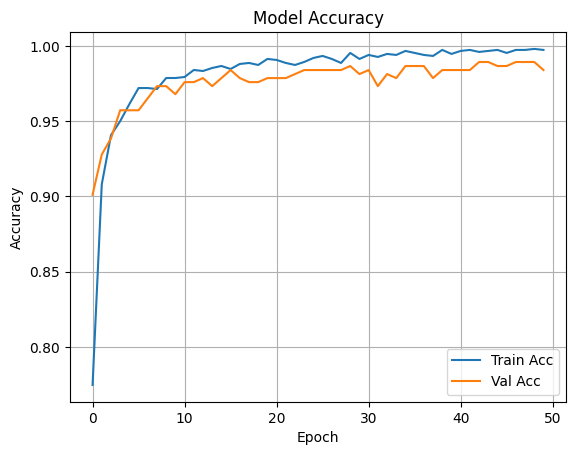

In [18]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

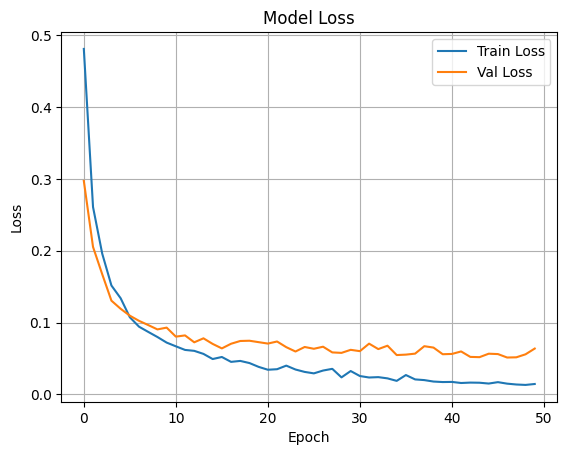

In [19]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

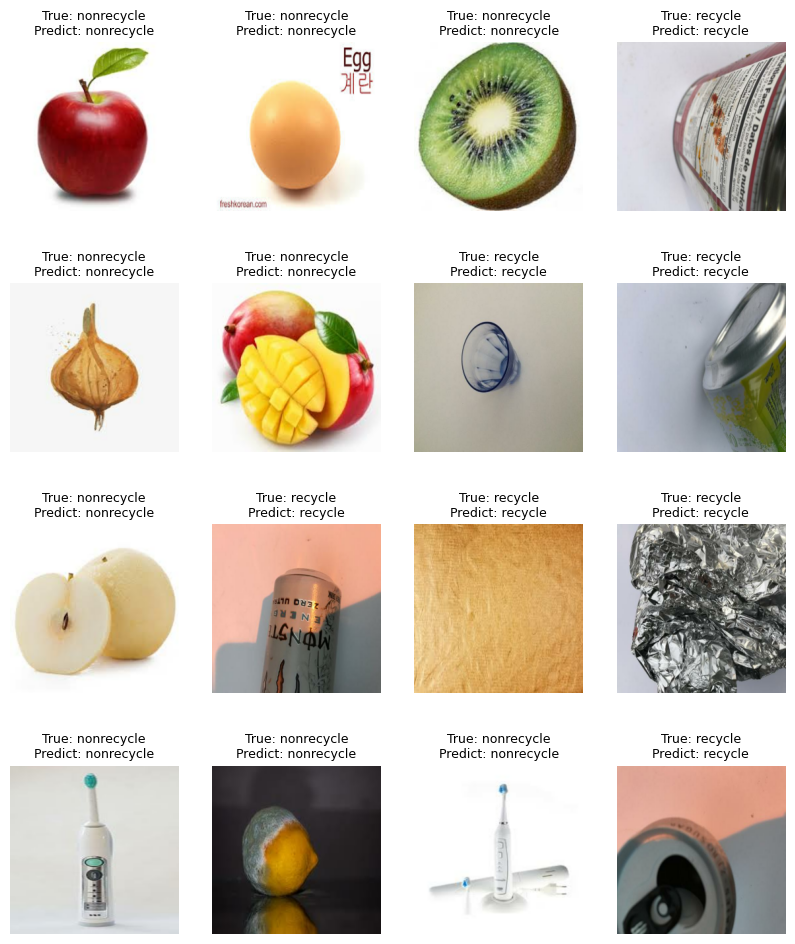

In [22]:
plt.figure(figsize=(10, 12))

for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Binary prediction (single value between 0 and 1)
        pred_prob = mobile_net_model.predict(images[i:i+1], verbose=0)[0][0]
        pred_class = 1 if pred_prob > 0.5 else 0
        predicted_label = class_names[pred_class]

        true_label = class_names[labels[i].numpy()]

        plt.title(f"True: {true_label}\nPredict: {predicted_label}", fontsize=9)
        ax.axis("off")

In [23]:
from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = mobile_net_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int)) 

print(classification_report(y_true, y_pred, target_names=["Non-Recyclable", "Recyclable"]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
                precision    recall  f1-score   support

Non-Recyclable       1.00      0.97      0.98       186
    Recyclable       0.97      1.00      0.98       188

      accuracy                           0.98       374
     macro avg       0.98      0.98      0.98       374
  weighted avg       0.98      0.98      0.98       374



In [24]:
mobile_net_model.save(r"C:\Users\Hassan Hallal\OneDrive\Desktop\waste\waste_model2.h5")